### Flood Mapping using Sentinel-1 GRD Workflow 
This notebook demonstrates a flood mapping workflow using Sentinel-1 Ground Range Detected (GRD) product. The process involves  preprocessing and generating a final flood classification map.   
  
**Study Area and Data**  
1. Area of Interest : Valencia Spain [-0.33563, 39.21757]  
2. Data source: ASF (Alaska Satellite Facility) search portal with the following parameters: GRD-HD, ascending orbit, instrument IW, and VV+VH polarizations.  

In [ ]:
# Importing functions from package--
from pysarflow import read_grd_product, subset_AOI, apply_orbit_file, thermal_noise_removal, border_noise_removal, \
    radiometric_calibration, speckle_filter,terrain_correction, plotBand,export,\
    maskPermanentWater,generateFloodMask, preprocess_grd_product

In [2]:
event_product_path = "../data/S1A_IW_GRDH_1SDV_20241031T180256_20241031T180321_056350_06E71E_479F.SAFE"
# event_product_path = r"C:\Users\Ethel Ogallo\OneDrive - Universität Salzburg\Archive\S1A_IW_GRDH_1SDV_20241031T180256_20241031T180321_056350_06E71E_479F.SAFE"

#### Pre-processing

**Read grd file and subsetting**

Reading SAR product from: ../data/S1A_IW_GRDH_1SDV_20241031T180256_20241031T180321_056350_06E71E_479F.SAFE...
	Product read successfully.


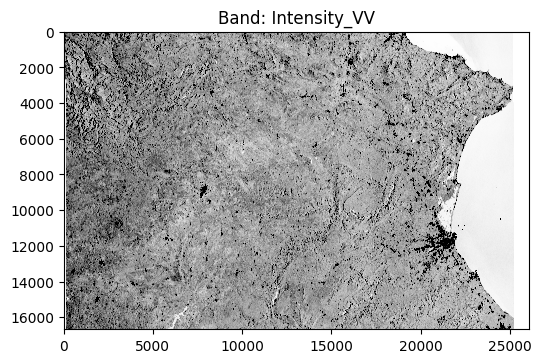

	Subsetting using bounding box: [-0.547119, 38.953446, -0.124146, 39.481696]

100% done.
Columns (width): 4625
Rows (height): 6295
	Product subsetted.


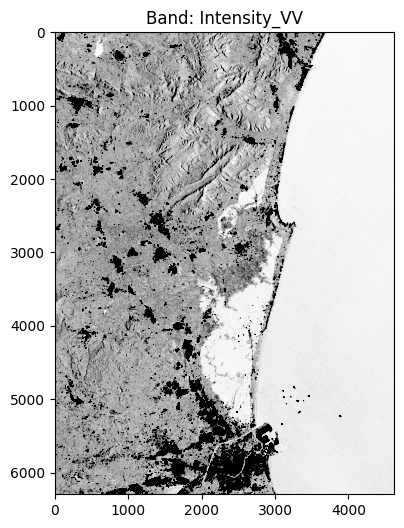

In [3]:
# read the .SAFE data
event_product=read_grd_product(event_product_path)
plotBand(event_product, "Intensity_VV", 
         vmin=0, vmax=100000, figsize=(6,4))

# clip to AOI
aoi_bbox=[-0.547119, 38.953446,-0.124146,39.481696]
product_subset=subset_AOI(product=event_product, bbox=aoi_bbox)
plotBand(product_subset, "Intensity_VV", 
         vmin=0, vmax=100000, figsize=(8,6))


**Apply orbit file, thermal noise and border noise removal**

In [4]:
# apply orbit
product_orbit = apply_orbit_file(product_subset)

# remove thermal noise
product_tnr = thermal_noise_removal(product_orbit)

# remove border noise
product_bnr = border_noise_removal(product_tnr)

	Applying Orbit File...

100% done.
	Orbit File applied.
	Performing thermal noise removal...

100% done.
	Thermal noise removed.
	Performing border noise removal...
version = 3.8

100% done.
	Border noise removed.


**Radiometric callibration**

	Radiometric calibration for polarization(s): VV...

100% done.
	Radiometric calibration completed.


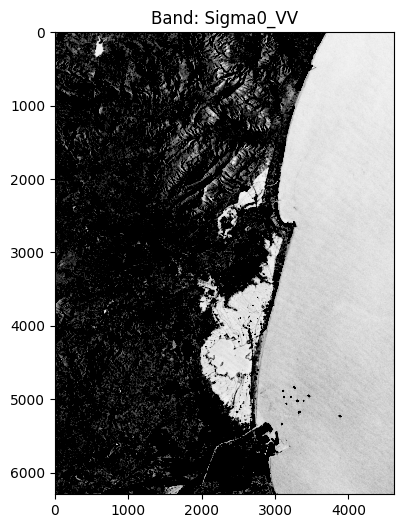

In [5]:
product_calibrated = radiometric_calibration(product_bnr, polarization='VV', pols_selected='VV')
plotBand(product_calibrated, "Sigma0_VV", 
         vmin=0, vmax=0.1, figsize=(8,6))

**Speckle Filtering**


Columns (width): 4625
Rows (height): 6295
	Speckle filter completed.
100% done.


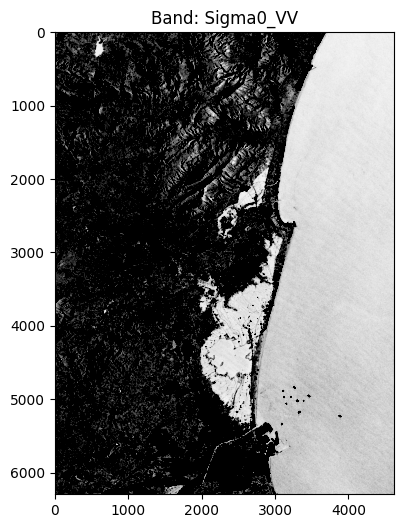

In [6]:
product_filtered = speckle_filter(product_calibrated)
plotBand(product_filtered, "Sigma0_VV", 
         vmin=0, vmax=0.1,figsize=(8,6))

**Terrain correction**


100% done.

100% done.
	Terrain correction completed.


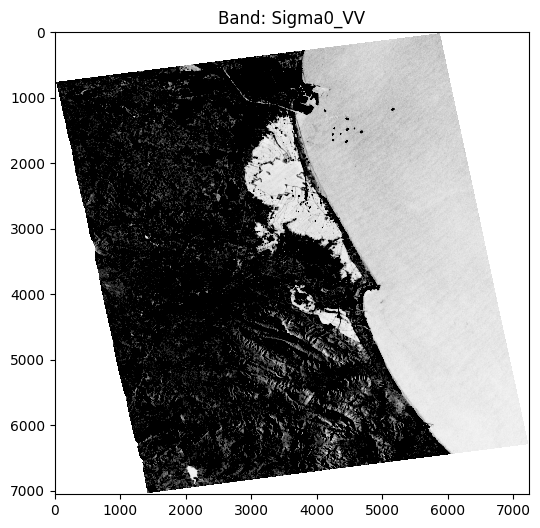

In [7]:
preprocessed_product = terrain_correction(product_filtered)
plotBand(preprocessed_product, "Sigma0_VV", 
         vmin=0, vmax=0.1,figsize=(8,6))

#### Flood mapping

In [8]:
# mask out open permanent water
product_perm_water= maskPermanentWater(preprocessed_product)

# Apply threshold to mask flooded area 
product_flood_mapping = generateFloodMask(product_perm_water, threshold=0.04)

Masking permanent waster based on landcover data

50%100% done.

100% done.

100% done.
	Masking permanent water complete.

100% done.


**Exporting result**

In [10]:
output_file_path="./flood_map.tif"
export(product_flood_mapping,output_file_path)

Exporting product to ./flood_map.tif (GeoTIFF)...
	Export complete.


**Visualization**

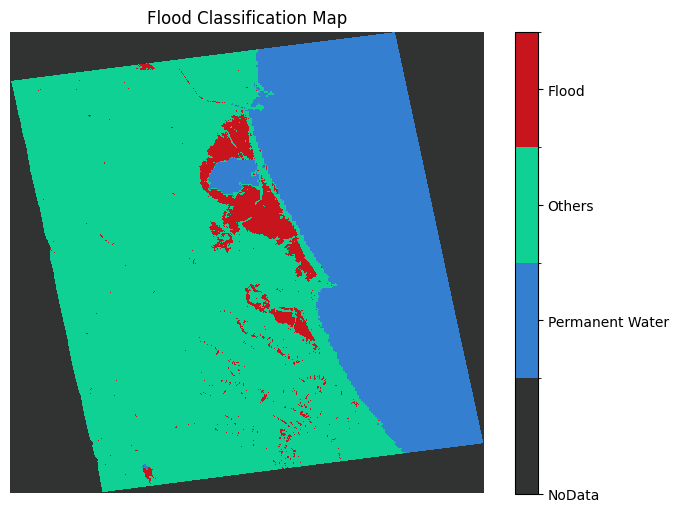

In [11]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm

# Open with rasterio
with rasterio.open(output_file_path) as src:
    data = src.read(1)  # first band
    profile = src.profile

# Define classes
classes = {
    -9999: "NoData",
    0: "Permanent Water",
    1: "Others",
    2: "Flood"
}

# Define colors in the same order
colors = ["#313333", "#347fcf", "#0fd194", "#c7141d"] 
cmap = ListedColormap(colors)

# Define boundaries and normalization
bounds = [-9999, -0.5, 0.5, 1.5, 2.5]  # cutoffs between classes
norm = BoundaryNorm(bounds, cmap.N)

# Plot
plt.figure(figsize=(8, 6))
im = plt.imshow(data, cmap=cmap, norm=norm)
cbar = plt.colorbar(im, ticks=[-9999, 0, 1, 2])
cbar.ax.set_yticklabels([classes[c] for c in [-9999, 0, 1, 2]])
plt.title("Flood Classification Map")
plt.axis("off")
plt.show()


#### Additional: Run all preprocessing steps with one function

In [12]:
# config = {
#     "aoi_bbox": [-0.547119, 38.953446,-0.124146,39.481696],   # optional
#     "polarization": "VV",
#     "pols_selected": "VV",
#     "filter": "Lee",
#     "filterSizeX": '7',
#     "filterSizeY": '7',
#     "demName": 'SRTM 3Sec',
#     "pixelSpacingInMeter": '10',
#     "demResamplingMethod": "BILINEAR_INTERPOLATION",
#     "imgResamplingMethod": "BICUBIC_INTERPOLATION"
# }

# preprocessed_product=preprocess_grd_product(event_product_path, config)